In [43]:
#import packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.callbacks import *
from keras.optimizers import Adam
from statistics import mean
import os
from numpy import array
import tensorflow as tf
import time

In [44]:
#read data:
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)
tesla

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,248.839996,4527600
2015-05-18,247.000000,249.899994,246.000000,248.750000,248.750000,3353200
2015-05-19,248.429993,251.000000,246.149994,247.139999,247.139999,3674200
2015-05-20,247.130005,247.740005,241.369995,244.350006,244.350006,3755600
2015-05-21,243.029999,246.619995,242.360001,245.619995,245.619995,1970600
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,819.419983,16130100
2020-05-11,790.510010,824.000000,785.000000,811.289978,811.289978,16471100
2020-05-12,827.000000,843.289978,808.000000,809.409973,809.409973,15906900


In [45]:
# Normalize data and create Xarr the input to the model and Yarr the actual output desired 
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = tesla
dataframe_tsla = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

tesla

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-15,0.130072,0.116005,0.133492,0.135922,0.135922,0.063416
2015-05-18,0.134002,0.116619,0.138098,0.135806,0.135806,0.043918
2015-05-19,0.135833,0.117970,0.138295,0.133725,0.133725,0.049247
2015-05-20,0.134169,0.113965,0.132005,0.130120,0.130120,0.050599
2015-05-21,0.128920,0.112589,0.133308,0.131761,0.131761,0.020963
...,...,...,...,...,...,...
2020-05-08,0.833931,0.821884,0.849981,0.873344,0.873344,0.256050
2020-05-11,0.829758,0.821884,0.847336,0.862837,0.862837,0.261712
2020-05-12,0.876469,0.845581,0.877600,0.860407,0.860407,0.252344


In [46]:
# divide data for training and testing:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=1,window_size = 200)
print(X_train.shape)

(200, 6)


# 1. MAPE for Tesla LSTM model:

In [6]:
# Model:
file_path = 'daily_mlp_model_weights.h5'
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))   
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.005)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16,dropout = 0.30))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 2879.708582162857 seconds 
Mean Validation loss= 0.01358168


0.01358168


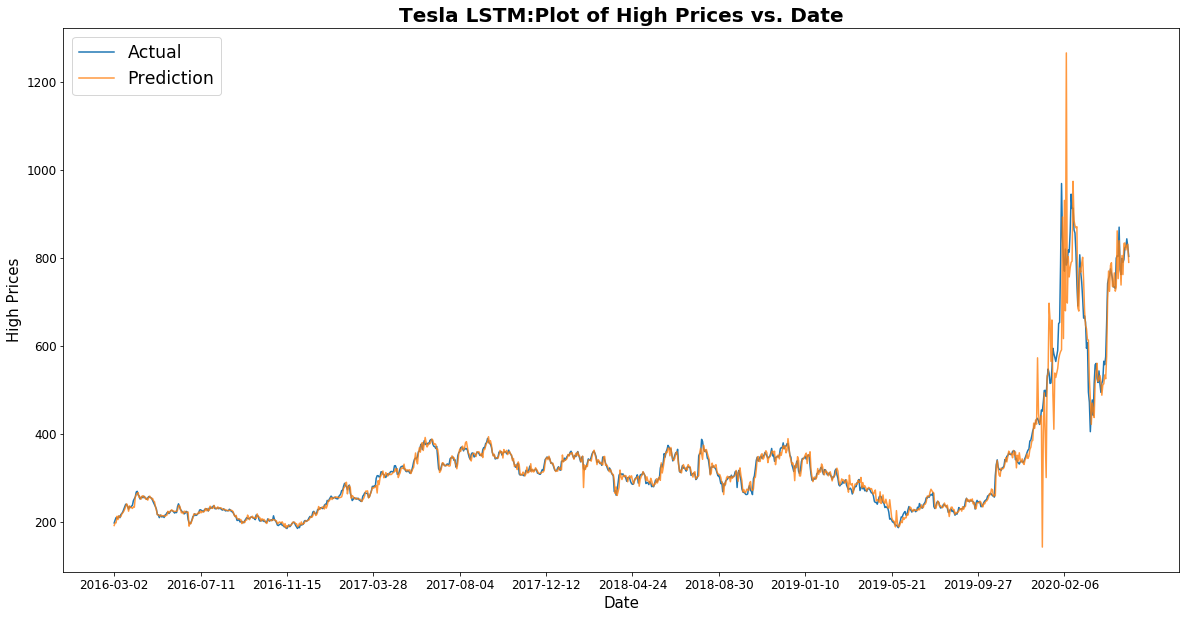

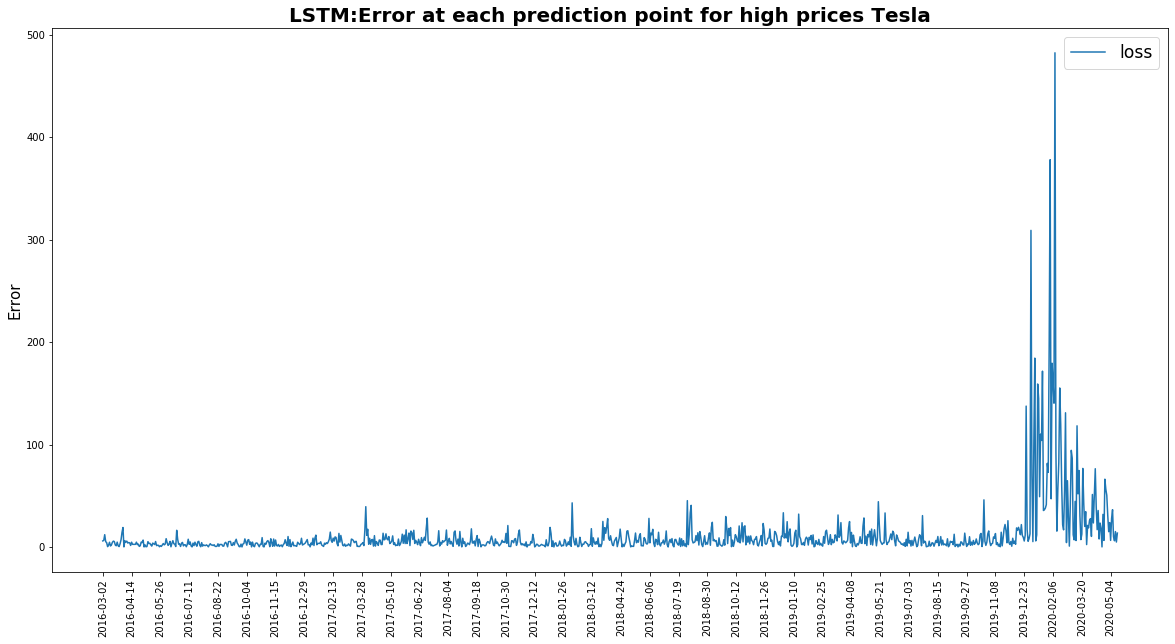

In [8]:
actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
print(mean(val_loss))

def evaluate_model(actual,predicted,dates,title_str,y_label):

    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel(y_label,fontsize=15)
    plt.plot((actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")


def mae(y_predicted,y_actual,dates,title_str):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")
 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))
title_str = 'Tesla LSTM:Plot of High Prices vs. Date'
y_label = 'High Prices'
evaluate_model(actual_high,predicted_high ,np.array(predicted_dates),title_str,y_label )
#actual_low,predicted_low,actual_close,predicted_close)

title_str ='LSTM:Error at each prediction point for high prices Tesla'
mae(predicted_high,actual_high,np.array(predicted_dates),title_str)


In [42]:
# Mean Absolute Percentage Error Calculation:

def mape(actual,predicted):
    return (sum((abs(actual - predicted))/actual)/len(actual))[0]
tsla_lstm_mape_high = mape(actual_high,predicted_high)
tsla_lstm_mape_low = mape(actual_low,predicted_low)
tsla_lstm_mape_close = mape(actual_low,predicted_low)
print("MAPE for high,low,close prices = ",tsla_lstm_mape_high ,tsla_lstm_mape_low ,tsla_lstm_mape_close)

MAPE for high,low,close prices =  0.039519513068924074 0.03666849725016718 0.03666849725016718


In [62]:
tsla_lstm_mape = (tsla_lstm_mape_high + tsla_lstm_mape_low + tsla_lstm_mape_close)
print ("MAPE for TSLA LSTM model = ",tsla_lstm_mape)

MAPE for TSLA LSTM model =  0.08560251030308727


# 2. MAPE for Tesla MLP Model:

In [47]:
import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(3,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 1265.0788080692291 seconds 
Mean Validation loss= 0.00918993
[0.00956259, 0.0092387, 0.00928654, 0.00887816, 0.00898365]


In [52]:
# Mean Absolute Percentage Error Calculation:

def mape(actual,predicted):
    return (sum((abs(actual - predicted))/actual)/len(actual))[0]

actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
print(mean(val_loss))

 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))

tsla_mlp_mape_high = mape(actual_high,predicted_high)
tsla_mlp_mape_low = mape(actual_low,predicted_low)
tsla_mlp_mape_close = mape(actual_low,predicted_low)
print("MAPE for high,low,close prices for Tesla MLP Model = ",tsla_mlp_mape_high ,tsla_mlp_mape_low ,tsla_mlp_mape_close)

0.009189928
MAPE for high,low,close prices for Tesla MLP Model =  0.02473869678777274 0.024738697261940296 0.024738697261940296
MAPE for TSLA MLP model =  0.024738697103884443


In [63]:
tsla_mlp_mape = (tsla_mlp_mape_high + tsla_mlp_mape_low + tsla_mlp_mape_close)
print ("MAPE for TSLA MLP model = ",tsla_mlp_mape)

MAPE for TSLA MLP model =  0.07421609131165333


# 3. MAPE for Tesla CNN Model:

In [53]:
import time
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='adam', loss="mean_absolute_error")
    
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 532.1307637691498 seconds 
Mean Validation loss= 0.00899332
[0.00897247, 0.00886181, 0.00932371, 0.00891562, 0.00889297]


In [80]:
# Mean Absolute Percentage Error Calculation:

def mape(actual,predicted):
    return (sum((abs(actual - predicted))/actual)/len(actual))[0]

actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
print(mean(val_loss))

 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))

tsla_cnn_mape_high = mape(actual_high,predicted_high)
tsla_cnn_mape_low = mape(actual_low,predicted_low)
tsla_cnn_mape_close = mape(actual_low,predicted_low)
print("MAPE for high,low,close prices for Tesla CNN Model = ",tsla_cnn_mape_high ,tsla_cnn_mape_low ,tsla_cnn_mape_close)
tsla_cnn_mape = tsla_cnn_mape_high + tsla_cnn_mape_low + tsla_cnn_mape_close
print ("MAPE for TSLA CNN model = ",tsla_cnn_mape)

0.008993316
MAPE for high,low,close prices for Tesla CNN Model =  0.024879302272984627 0.024879302272984637 0.024879302272984637
MAPE for TSLA CNN model =  0.07463790681895391


# For GM:

In [121]:
#read data
np.random.seed(7)
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0)

In [122]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = gm
dataframe_gm = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [118]:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)

# 4. MAPE for GM MLP Model:

In [110]:
 import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))
    
model_mlp.add(tf.keras.layers.Dense(100,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(3,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,10):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
starting sample: 5 ...
completed sample: 5 ...
starting sample: 6 ...
completed sample: 6 ...
starting sample: 7 ...
completed sample: 7 ...
starting sample: 8 ...
completed sample: 8 ...
starting sample: 9 ...
completed sample: 9 ...
time taken for execution : 2513.735449075699 seconds 
Mean Validation loss= 0.0140794


In [113]:
# Mean Absolute Percentage Error Calculation:

def mape(actual,predicted):
    mape = 0
    for indx in range(0,len(actual)):
        if actual[indx]!= 0:
            mape = mape + abs((actual[indx] - predicted[indx])/actual[indx])
    return (mape/len(actual))[0]

actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
print(mean(val_loss))

 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))

gm_mlp_mape_high = mape(actual_high,predicted_high)
gm_mlp_mape_low = mape(actual_low,predicted_low)
gm_mlp_mape_close = mape(actual_low,predicted_low)
print("MAPE for high,low,close prices for GM MLP Model = ",gm_mlp_mape_high ,gm_mlp_mape_low ,gm_mlp_mape_close)
gm_mlp_mape = gm_mlp_mape_high + gm_mlp_mape_low + gm_mlp_mape_close
print ("MAPE for GM MLP model = ",tsla_cnn_mape)

0.014079397
MAPE for high,low,close prices for GM MLP Model =  0.016429943276257665 0.016530261358939626 0.016530261358939626
MAPE for GM MLP model =  0.07463790681895391


# 5. MAPE for GM CNN Model:

In [120]:
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='adam', loss="mean_absolute_error")

from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...


IndexError: list index out of range

In [104]:
# Mean Absolute Percentage Error Calculation:

def mape(actual,predicted):
    mape = 0
    for indx in range(0,len(actual)):
        if actual[indx]!= 0:
            mape = mape + abs((actual[indx] - predicted[indx])/actual[indx])
    return (mape/len(actual))[0]

actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
print(mean(val_loss))

 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))

gm_cnn_mape_high = mape(actual_high,predicted_high)
gm_cnn_mape_low = mape(actual_low,predicted_low)
gm_cnn_mape_close = mape(actual_low,predicted_low)
print("MAPE for high,low,close prices for GM CNN Model = ",gm_cnn_mape_high ,gm_cnn_mape_low ,gm_cnn_mape_close)
gm_cnn_mape = gm_cnn_mape_high + gm_cnn_mape_low + gm_cnn_mape_close
print ("MAPE for GM CNN model = ",gm_cnn_mape)

0.014538236
MAPE for high,low,close prices for GM CNN Model =  0.06657407365900012 0.06657407365900012 0.06657407365900012
MAPE for GM CNN model =  0.19972222097700035


array([[0.7397163 ],
       [0.73829797],
       [0.75957453],
       [0.68581573],
       [0.67340428],
       [0.67659577],
       [0.69290779],
       [0.69609932],
       [0.68546102],
       [0.65567378],
       [0.68120573],
       [0.67836882],
       [0.6847518 ],
       [0.68687949],
       [0.70070928],
       [0.66666676],
       [0.64219857],
       [0.63758875],
       [0.61666676],
       [0.64255325],
       [0.63865254],
       [0.65212775],
       [0.65638304],
       [0.64397172],
       [0.62446807],
       [0.6219858 ],
       [0.68156031],
       [0.68439726],
       [0.66879431],
       [0.65602846],
       [0.62907804],
       [0.61843977],
       [0.60425531],
       [0.59255325],
       [0.56028378],
       [0.55638303],
       [0.54609931],
       [0.56489374],
       [0.56453906],
       [0.57411353],
       [0.59078023],
       [0.59113481],
       [0.61631208],
       [0.63439726],
       [0.63581573],
       [0.59645399],
       [0.57163126],
       [0.547

# 6. MAPE for GM LSTM Model:

In [154]:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    x_val = Xarr[start+window_size+2:start+window_size+pw+2]
    y_val = yarr[start+window_size+2:start+window_size+pw+2]
    date_val =Datearr[start+window_size+2:start+window_size+pw+2]
    return X_train,X_test,y_train,y_test,Date_train,Date_test,x_val,y_val,date_val

trn_size = len(Xarr)

In [127]:
file_path = 'daily_mlp_model_weights.h5'
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))      
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,4):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window-4):
        X_train,X_test,y_train,y_test,Date_train,Date_test,X_val,y_val,date_val = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_val, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(date_val[0])
        actual_high.append(y_val[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
time taken for execution : 2153.204849720001 seconds 
Mean Validation loss= 0.02392194


In [130]:
actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
mean(val_loss)

 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))

In [131]:
# Mean Absolute Percentage Error Calculation:

def mape(actual,predicted):
    mape = 0
    for indx in range(0,len(actual)):
        if actual[indx]!= 0:
            mape = mape + abs((actual[indx] - predicted[indx])/actual[indx])
    return (mape/len(actual))[0]

gm_lstm_mape_high = mape(actual_high,predicted_high)
gm_lstm_mape_low = mape(actual_low,predicted_low)
gm_lstm_mape_close = mape(actual_low,predicted_low)
print("MAPE for high,low,close prices for GM LSTM Model = ",gm_lstm_mape_high ,gm_lstm_mape_low ,gm_lstm_mape_close)
gm_lstm_mape = gm_lstm_mape_high + gm_lstm_mape_low + gm_lstm_mape_close
print ("MAPE for GM LSTM model = ",gm_lstm_mape)

MAPE for high,low,close prices for GM LSTM Model =  0.028228951029656214 0.028235843956259325 0.028235843956259325
MAPE for GM LSTM model =  0.08470063894217486


# For FORD:

In [156]:
#read data:
np.random.seed(7)
ford = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Ford 5 years.csv', header=0, index_col=0)


In [157]:
df = ford
dataframe_ford = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

ford

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-15,0.959860,0.969352,0.974160,0.982862,0.966201,0.049889
2015-05-18,0.977312,0.982487,0.989664,0.991431,0.975584,0.052362
2015-05-19,0.987784,0.981611,0.989664,0.984576,0.968078,0.032961
2015-05-20,0.983421,0.975482,0.973299,0.967438,0.949312,0.065305
2015-05-21,0.960733,0.974606,0.973299,0.985433,0.969016,0.072315
...,...,...,...,...,...,...
2020-05-08,0.060209,0.072680,0.085271,0.105398,0.149157,0.417663
2020-05-11,0.079407,0.067426,0.093885,0.095116,0.134605,0.302773
2020-05-12,0.076789,0.070053,0.086994,0.083119,0.117628,0.282113


# 7. MAPE for Ford MLP Model:

In [158]:
import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(3,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,2):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window-3):
        X_train,X_test,y_train,y_test,Date_train,Date_test,X_val,y_val,date_val = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_val, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = date_val.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_val)
            predicted_dates.append(date_val.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
time taken for execution : 494.44265031814575 seconds 
Mean Validation loss= 0.01007135
[0.01031321, 0.00982949]


In [161]:
actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
mean(val_loss)

 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))

# Mean Absolute Percentage Error Calculation:

def mape(actual,predicted):
    mape = 0
    for indx in range(0,len(actual)):
        if actual[indx]!= 0:
            mape = mape + abs((actual[indx] - predicted[indx])/actual[indx])
    return (mape/len(actual))[0]

ford_mlp_mape_high = mape(actual_high,predicted_high)
ford_mlp_mape_low = mape(actual_low,predicted_low)
ford_mlp_mape_close = mape(actual_low,predicted_low)
print("MAPE for high,low,close prices for Ford MLP Model = ",ford_mlp_mape_high ,ford_mlp_mape_low ,ford_mlp_mape_close)
ford_mlp_mape = ford_mlp_mape_high + ford_mlp_mape_low + ford_mlp_mape_close
print ("MAPE for FORD MLP model = ",ford_mlp_mape)

MAPE for high,low,close prices for Ford MLP Model =  0.013378458016131894 0.01344634736466224 0.01344634736466224
MAPE for FORD MLP model =  0.040271152745456375


# 8. MAPE for Ford CNN Model:

In [164]:
import time
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='adam', loss="mean_absolute_error")
    
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,10):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window-3):
        X_train,X_test,y_train,y_test,Date_train,Date_test,X_val,y_val,date_val = build_data(trn,pw=1,window_size = window)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_val, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = date_val.tolist()
            actual_high = y_val.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_val)
            predicted_dates.append(date_val.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
starting sample: 5 ...
completed sample: 5 ...
starting sample: 6 ...
completed sample: 6 ...
starting sample: 7 ...
completed sample: 7 ...
starting sample: 8 ...
completed sample: 8 ...
starting sample: 9 ...
completed sample: 9 ...
time taken for execution : 1062.2472281455994 seconds 
Mean Validation loss= 0.00946521
[0.0096206, 0.00961578, 0.00961954, 0.00954225, 0.00931341, 0.00932812, 0.00918763, 0.00944533, 0.00953059, 0.00944885]


In [165]:
actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
mean(val_loss)

 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))

# Mean Absolute Percentage Error Calculation:

def mape(actual,predicted):
    mape = 0
    for indx in range(0,len(actual)):
        if actual[indx]!= 0:
            mape = mape + abs((actual[indx] - predicted[indx])/actual[indx])
    return (mape/len(actual))[0]

ford_cnn_mape_high = mape(actual_high,predicted_high)
ford_cnn_mape_low = mape(actual_low,predicted_low)
ford_cnn_mape_close = mape(actual_low,predicted_low)
print("MAPE for high,low,close prices for Ford CNN Model = ",ford_cnn_mape_high ,ford_cnn_mape_low ,ford_cnn_mape_close)
ford_cnn_mape = ford_cnn_mape_high + ford_cnn_mape_low + ford_cnn_mape_close
print ("MAPE for FORD CNN model = ",ford_cnn_mape)

MAPE for high,low,close prices for Ford MLP Model =  0.014484502430778111 0.01613245291448578 0.01613245291448578
MAPE for FORD MLP model =  0.04674940825974967


In [167]:
print("MAPE for high,low,close prices for Ford CNN Model = ",ford_cnn_mape_high ,ford_cnn_mape_low ,ford_cnn_mape_close)
ford_cnn_mape = ford_cnn_mape_high + ford_cnn_mape_low + ford_cnn_mape_close
print ("MAPE for FORD CNN model = ",ford_cnn_mape)

MAPE for high,low,close prices for Ford CNN Model =  0.014484502430778111 0.01613245291448578 0.01613245291448578
MAPE for FORD CNN model =  0.04674940825974967


# 9. MAPE for Ford LSTM Model:

In [166]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window-3):
        X_train,X_test,y_train,y_test,Date_train,Date_test,X_val,y_val,Date_val = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_val, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_val[0])
        actual_high.append(y_val[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 2910.0112657546997 seconds 
Mean Validation loss= 0.01553635


In [168]:
actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
mean(val_loss)

 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))

# Mean Absolute Percentage Error Calculation:

def mape(actual,predicted):
    mape = 0
    for indx in range(0,len(actual)):
        if actual[indx]!= 0:
            mape = mape + abs((actual[indx] - predicted[indx])/actual[indx])
    return (mape/len(actual))[0]

ford_lstm_mape_high = mape(actual_high,predicted_high)
ford_lstm_mape_low = mape(actual_low,predicted_low)
ford_lstm_mape_close = mape(actual_low,predicted_low)
print("MAPE for high,low,close prices for Ford LSTM Model = ",ford_lstm_mape_high ,ford_lstm_mape_low ,ford_lstm_mape_close)
ford_lstm_mape = ford_lstm_mape_high + ford_lstm_mape_low + ford_lstm_mape_close
print ("MAPE for FORD LSTM model = ",ford_lstm_mape)

MAPE for high,low,close prices for Ford LSTM Model =  0.0373788847617596 0.03860040130301956 0.03860040130301956
MAPE for FORD LSTM model =  0.11457968736779872


In [169]:
def mae(actual,predicted):
    mape = 0
    for indx in range(0,len(actual)):
        if actual[indx]!= 0:
            mape = mape + abs((actual[indx] - predicted[indx]))
    return (mape/len(actual))[0]
ford_lstm_mae_high = mape(actual_high,predicted_high)
ford_lstm_mae_low = mape(actual_low,predicted_low)
ford_lstm_mae_close = mape(actual_low,predicted_low)
(ford_lstm_mae_high + ford_lstm_mae_low + ford_lstm_mae_close)/3

0.03819322912259957

In [170]:
for indx in range(0,len(actual_high)):
        if actual_high[indx]!= 0:
            print(abs((actual_high[indx] - predicted_high[indx])))

[0.01925201]
[0.13390477]
[0.19573353]
[0.26665841]
[0.17601896]
[0.3852489]
[0.09988808]
[0.00312651]
[0.17160599]
[0.11473585]
[0.05084113]
[0.07582806]
[0.14208167]
[0.261141]
[0.09530134]
[0.29993656]
[0.02864339]
[0.03723409]
[0.26816245]
[0.09930268]
[0.24107455]
[0.171083]
[0.19205808]
[0.26914682]
[0.01752899]
[0.00648782]
[0.28737203]
[0.28861243]
[0.08785016]
[0.36222514]
[0.03434379]
[0.03993208]
[0.15792905]
[0.15456591]
[0.00823014]
[0.11629597]
[0.24069264]
[0.52893153]
[0.22171266]
[0.05983094]
[0.30609171]
[0.38325648]
[0.08144385]
[0.00359022]
[0.09693041]
[0.14240469]
[0.12474434]
[0.12056803]
[0.05448877]
[0.00061517]
[0.19330218]
[0.03913832]
[0.232093]
[0.04250962]
[0.22196304]
[0.00528558]
[0.16709291]
[0.0266197]
[0.07078916]
[0.03851944]
[0.14161568]
[0.14598465]
[0.23054682]
[0.01578621]
[0.0826633]
[0.03946384]
[0.13787065]
[0.16251786]
[0.24066117]
[0.005704]
[0.23491798]
[0.1109382]
[0.13328488]
[0.13790621]
[0.08595402]
[0.01418151]
[0.15390833]
[0.59109812

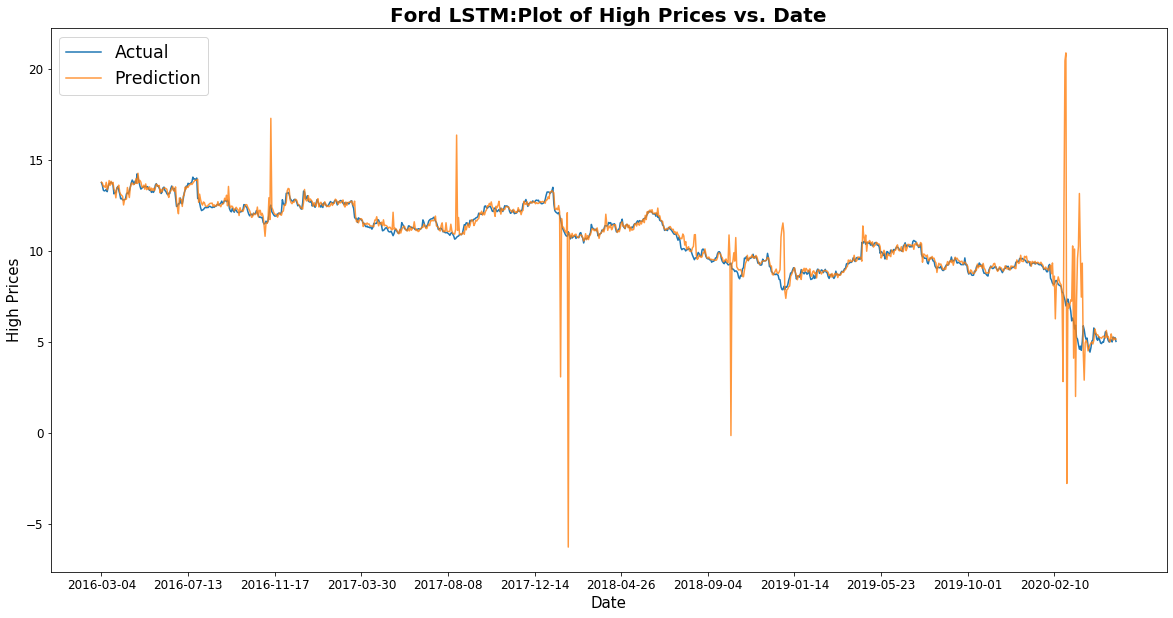

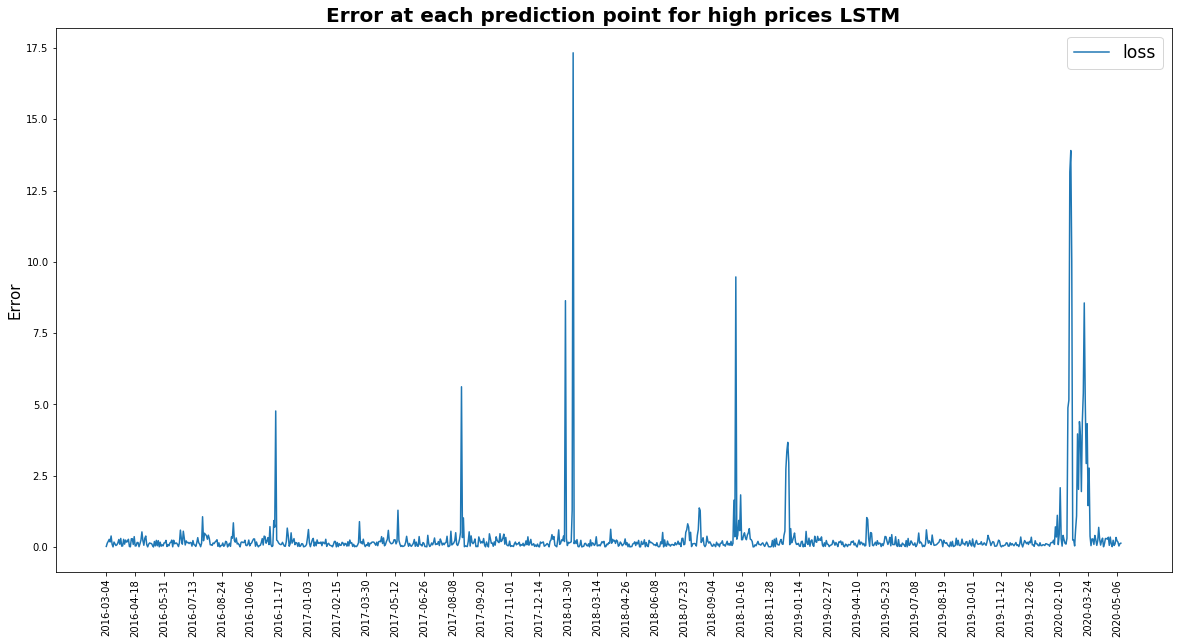

In [172]:
def evaluate_model(actual,predicted,dates,title_str,y_label):

    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel(y_label,fontsize=15)
    plt.plot((actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

def mae(y_predicted,y_actual,dates,title_str):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

title_str = 'Ford LSTM:Plot of High Prices vs. Date'
y_label = 'High Prices'
evaluate_model(actual_high,predicted_high ,np.array(predicted_dates),title_str,y_label )
#actual_low,predicted_low,actual_close,predicted_close)

title_str ='Error at each prediction point for high prices LSTM'
mae(predicted_high,actual_high,np.array(predicted_dates),title_str)